# 编程实践：量子模拟器

In [ ]:
# Numpy 是一个功能强大的Python库，主要用于对多维数组执行计算。
# Simulator 是模拟器，可以模拟量子计算机的计算过程。
import numpy as np                          # 导入numpy库并简写为np
from mindquantum.simulator import Simulator # 导入模拟器

# Simulator 中维护着一个量子态，初始为|0⟩态。
sim = Simulator('mqvector', 1)  # 实例化'mqvector'模拟器,量子比特数为1
print(sim)                      # 打印模拟器信息

In [ ]:
# 通过 set_qs() 可以将量子态设置为任意的非零列向量，接口会自动进行归一化。
plus_state = np.array([1, 1])   # 构造¦+⟩态
sim.set_qs(plus_state)          # 将量子态设置为¦+⟩态

quantum_state = sim.get_qs()    # 获取当前量子态
ket = sim.get_qs(ket=True)      # 获取当前量子态的狄拉克符号形式
print('quantum state:', quantum_state)
print('ket:\n', ket)

# 编程实践：量子门

In [ ]:
from mindquantum.core.gates import X, Y, H      # 导入量子门
from mindquantum.simulator import Simulator     # 导入模拟器

# 每个量子门都有 matrix() 方法，可以获取该量子门的矩阵形式。
print('Gate name:', X)
gateX = X.matrix()
print(gateX)

In [ ]:
print('Gate name:', Y)
gateY = Y.matrix()
print(gateY)

In [ ]:
print('Gate name:', H)
gateH = H.matrix()
print(gateH)

In [ ]:
# 调用 Simulator 的 apply_gate() 接口可以将量子门作用在量子比特上，使量子态发生演化。
# on() 方法可以指定量子门作用在哪个量子比特上（目标比特），受哪些比特控制（控制比特）。
sim = Simulator('mqvector', 1)          # 实例化一个模拟器
sim.apply_gate(H.on(0))                 # 将H门作用于q0
print(sim)

# 编程实践：量子线路

In [ ]:
from mindquantum.core.gates import X, Y, H   # 导入量子门X, Y, H
from mindquantum.core.circuit import Circuit # 导入Circuit模块，用于搭建量子线路
from mindquantum.simulator import Simulator  # 导入模拟器

# 通过“+=”的方式可以轻松地将量子门添加到量子线路中。
circ = Circuit() 			# 实例化一个量子线路
circ += H.on(0)  			# 在线路上的第0个比特添加一个H门
circ += Y.on(0) 			# 在线路上的第0个比特添加一个Y门
circ += X.on(1) 			# 在线路上的第1个比特添加一个X门

print(circ)

In [ ]:
mat = circ.matrix() 		# 获取线路对应的矩阵
print('circuit matrix:\n', mat)

In [ ]:
# 调用 Simulator 的 apply_circuit() 接口可以将量子线路作用在量子比特上，使量子态发生演化。
sim = Simulator('mqvector', 2)  	# 实例化一个两比特的模拟器
sim.apply_circuit(circ)          	# 作用量子线路
print(sim)

# 编程实践：量子测量

In [ ]:
from mindquantum.core.gates import Measure, H, X, Y # 导入量子门X, Y, H和量子测量Measure
from mindquantum.core.circuit import Circuit        # 导入Circuit模块，用于搭建量子线路
from mindquantum.simulator import Simulator         # 导入模拟器

circ = Circuit()                    # 实例化一个量子线路
circ += H.on(0)                     # 在线路上的第0个比特添加一个H门
circ += Y.on(0)                     # 在线路上的第0个比特添加一个Y门
circ += X.on(1)                     # 在线路上的第1个比特添加一个X门

# Measure 与量子门类似，可以用“+=”的方式添加到量子线路中，用 on() 方法指定目标比特。
circ += Measure().on(0)             # 在线路上的第0个比特添加一个测量
circ += Measure().on(1)             # 在线路上的第1个比特添加一个测量

print(circ)

In [ ]:
# 调用 Simulator 的 sampling() 接口可以对某一线路的演化结果进行多次采样，获得量子测量的统计结果。
# 这一过程与真实量子计算机的运行方式相似。
sim = Simulator('mqvector', 2)              # 实例化一个两比特的模拟器
result = sim.sampling(circ, shots=1000) 	# 对该线路的演化结果进行1000次采样
print(result)

# 编程实践：通过量子神经网络对鸢尾花进行分类

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import mindspore as ms
from mindspore import Tensor
from mindspore.dataset import NumpySlicesDataset
from mindspore.nn import SoftmaxCrossEntropyWithLogits, Adam
from mindspore.train import Model, LossMonitor, Accuracy
from mindquantum.core.gates import X, RY
from mindquantum.core.operators import QubitOperator, Hamiltonian
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz, IQPEncoding
from mindquantum.simulator import Simulator
from mindquantum.framework import MQLayer

# load and preprocess data
data = load_iris()
iris_data = data.data[:100].astype(np.float32)
iris_target = data.target[:100].astype(int)

# add three products of adjacent features
iris_data = np.hstack([iris_data, iris_data[:, :3] * iris_data[:, 1:4]])

X_train, X_test, y_train, y_test = train_test_split(
    iris_data, iris_target, test_size=0.2
)

# build encoder and ansatz
n_qubits = 4
encoder = IQPEncoding(n_qubits).circuit
ansatz = HardwareEfficientAnsatz(
    n_qubits, single_rot_gate_seq=[RY], entangle_gate=X, depth=3
).circuit
circuit = encoder.as_encoder() + ansatz.as_ansatz()

# define Hamiltonians
hams = [Hamiltonian(QubitOperator(f"Z{i}")) for i in (2, 3)]

# create quantum layer
sim = Simulator("mqvector", n_qubits)
grad_ops = sim.get_expectation_with_grad(hams, circuit)
qnn = MQLayer(grad_ops)

# setup and train model
loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = Adam(qnn.trainable_params(), learning_rate=0.1)
model = Model(qnn, loss_fn, opt, metrics={"acc": Accuracy()})

dataset_args = {"features": X_train, "labels": y_train}
train_ds = NumpySlicesDataset(dataset_args, shuffle=False).batch(5)
test_ds = NumpySlicesDataset({"features": X_test, "labels": y_test}).batch(5)
model.train(20, train_ds, callbacks=[LossMonitor(16)])

# evaluate
res = model.eval(test_ds)
print(f"Accuracy: {res['acc']}")

pred = np.argmax(ms.ops.Softmax()(model.predict(Tensor(X_test))), axis=1)
print(f"Pred: {pred}")
print(f"True: {y_test}")

# 作业

在之前的“鸢尾花分类”任务中，我们成功用Hardware Efficient Ansatz训练出了能够正确进行分类的量子神经网络，但实际上可以用各种各样的量子线路结构作为Ansatz来训练，但是不同量子线路结构的表达能力可能会有显著区别，探索不同Ansatz的效果是一个有趣的课题。

**请尝试用以下两种Ansatz实现鸢尾花分类任务，观察训练出的量子神经网络的效果。**

Ansatz1：https://www.mindspore.cn/mindquantum/docs/zh-CN/master/algorithm/nisq/mindquantum.algorithm.nisq.Ansatz1.html

Ansatz2：https://www.mindspore.cn/mindquantum/docs/zh-CN/master/algorithm/nisq/mindquantum.algorithm.nisq.Ansatz2.html

tips：通过改变Ansatz层数、调整哈密顿量作用的比特位等方式，或许会有不一样的结果？

<img src="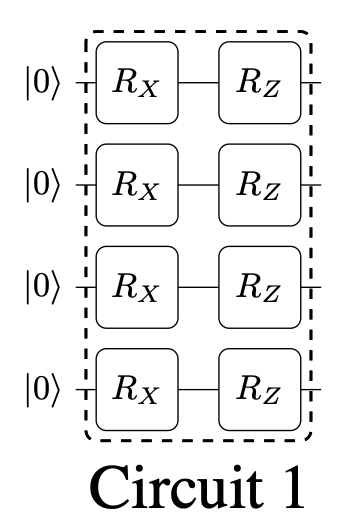
" width="100"/>

<img src="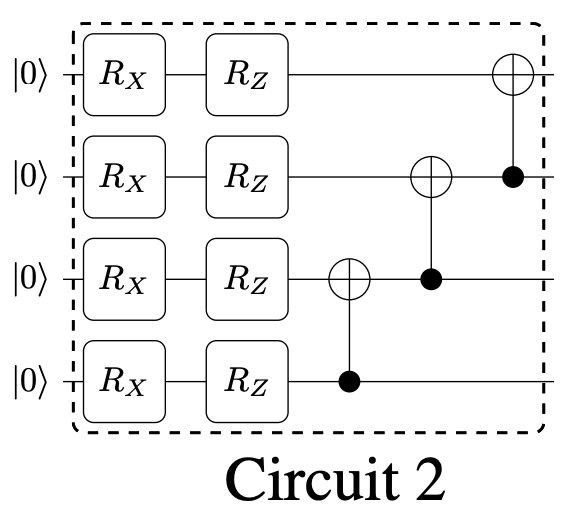
" width="200"/>

In [ ]:
# 请编写代码